# Final Project

## TRAC2- Transformer Models (BERT) - base uncased- Augmented data with word embeddings (Glove)

In this notebook we use data that has been augmented using word embeddings. 
We make use of GloVe (Pennington et al., 2014) to substitute similar words. GloVeAug (nlpaug library) use word embeddings to find most similar group of words to replace original word. 

Only the minority classes are augmented, achieving a factor of 6x.

Refer to the `TRAC2-Data-augmentation-nlpaug.ipynb` to check how the data was augmented.

In [82]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Package imports

In [83]:
!pip install transformers

In [84]:
!pip install datasets

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from datasets import load_dataset

from sklearn.preprocessing import label_binarize
from sklearn import metrics

## Helper functions

In [86]:
def from_logits_to_labels(pred, task):
    '''
    Returns labels based on predicted logits on labels [CAG,NAG,OAG] for task A. Task B is binary, and 'GEN' represents 
    the positive class.
    Parameters:
    pred: array with model prediction
    task: either 'A' or 'B'
    '''
    index_a = {0:'CAG', 1:'NAG', 2:'OAG'}
    index_b = {0:'GEN', 1:'NGEN'}
    
    if task == 'A':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_a.get)(highest_prob_class.astype(int))
        
    elif task == 'B':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_b.get)(highest_prob_class.astype(int))
    else:
        labels = []
        
    return labels  

In [87]:
def to_one_hot_labels(string_labels):
    '''
    Returns one-hot encoded labels from a multi-class label vector e.g. ['cat', 'dog', 'dog', 'lion', 'cat', ...] 
    Parameters:
    string_labels: 
    '''
    labels = pd.get_dummies(string_labels)
    labels = labels.to_numpy()
    
    return labels

In [88]:
# this is modified to get the prediction as parameter
# to avoid predicting again since inference takes time
def confusion_matrix_plot(pred_labels, true_labels, task, normalize=None):
    '''
    Returns a confusion matrix with a nice format.
    Parameters:
    pred_labels: predicted labels
    true_labels: true labels 
    task: 'A' or 'B'
    normalize: if want to normalize the confusion matrix normalize='true'
    '''
    
    # Create a confusion matrix
    cm = metrics.confusion_matrix(true_labels, pred_labels, normalize=normalize)
    cm = np.around(cm, 2)

    # Plot the confusion matrix
    if task == 'A':
        axis_labels = ['CAG', 'NAG', 'OAG']
    elif task == 'B':
        axis_labels = ['GEN', 'NGEN']

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")

    # Create the ticks and labels
    ax.set_xticks(np.arange(len(axis_labels)))
    ax.set_yticks(np.arange(len(axis_labels)))
    ax.set_xticklabels(axis_labels)
    ax.set_yticklabels(axis_labels)

    # Axis titles
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

    # Loop over data dimensions and create text annotations.
    for i in range(len(axis_labels)):
        for j in range(len(axis_labels)):
            text = ax.text(j, i, cm[i, j],ha="center", va="center", color="dimgrey", size=12)
    
    ax.set_title("Confusion Matrix", size=16, weight="bold")
    fig.tight_layout()
    plt.show()


In [89]:
def loss_accuracy_plots(training_history, xrange, task):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    xrange: range in x axis
    task: string used for the title in the plot
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # loss plot
    ax1.plot(training_history.history['loss'], color='black')
    ax1.plot(training_history.history['val_loss'], color='blue')
    ax1.set_title('Training and validation loss Sub-Task ' + task)
    ax1.legend(['training', 'development'])
    ax1.grid(which='both')
    ax1.set_xticks(np.arange(0, xrange, 2))
    
    # accuracy plot
    ax2.plot(training_history.history['categorical_accuracy'], color='black')
    ax2.plot(training_history.history['val_categorical_accuracy'], color='blue')
    ax2.set_title('Training and validation acccuracy Sub_Task ' + task)
    ax2.legend(['training', 'development'])
    ax2.grid(which='both')
    ax2.set_xticks(np.arange(0, xrange, 2))
    plt.show()
    

## Load data
Load training, development and test datasets.

In [90]:
# Load labels using pandas dataframes

train_labels_a = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_train_augm_glove_emb.csv')['Sub-task A']
train_labels_b = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_train_augm_glove_emb.csv')['Sub-task B']
dev_labels_a = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_dev.csv')['Sub-task A']
dev_labels_b = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_dev.csv')['Sub-task B']
test_labels_a = pd.read_csv('drive/MyDrive/w266/release-files/gold/trac2_eng_gold_a.csv')['Sub-task A']
test_labels_b = pd.read_csv('drive/MyDrive/w266/release-files/gold/trac2_eng_gold_b.csv')['Sub-task B']

In [91]:
# Load text data using Hugging Face datasets
# need to use the split argument even though we are not splitting. If not, data is loaded as DatasetDict
# to load as dataset need to include the split parameter
train_dataset = load_dataset('csv', data_files='drive/MyDrive/w266/release-files/eng/trac2_eng_train_augm_glove_emb.csv', split = 'train[:9373]')
dev_dataset = load_dataset('csv', data_files='drive/MyDrive/w266/release-files/eng/trac2_eng_dev.csv', split = 'train[:1066]')
test_dataset = load_dataset('csv', data_files='drive/MyDrive/w266/release-files/test/trac2_eng_test.csv', split = 'train[:1200]')

Using custom data configuration default-c6f77fbced0a0110
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-c6f77fbced0a0110/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)
Using custom data configuration default-98e2ce082b0629f1
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-98e2ce082b0629f1/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)
Using custom data configuration default-0ba61447556c92da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-0ba61447556c92da/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


## Encode labels

In [92]:
# encode labels Task A- [CAG,NAG,OAG]
train_labels_a_enc = to_one_hot_labels(train_labels_a)
dev_labels_a_enc = to_one_hot_labels(dev_labels_a)
test_labels_a_enc = to_one_hot_labels(test_labels_a)


In [93]:
# encode labels Task B- [GEN, NGEN]
train_labels_b_enc = to_one_hot_labels(train_labels_b)
dev_labels_b_enc = to_one_hot_labels(dev_labels_b)
test_labels_b_enc = to_one_hot_labels(test_labels_b)

## Prepare TensorFlow datasets for BERT

In [94]:
# remove columns to leave only the column with the posts. Column 'Text'
train_dataset = train_dataset.remove_columns(['ID', 'Sub-task B', 'Sub-task A'])
dev_dataset = dev_dataset.remove_columns(['ID', 'Sub-task A', 'Sub-task B'])
test_dataset = test_dataset.remove_columns('ID')

In [95]:
# define a BERT tokenizer
# use the bert-based-uncased tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

The tokenizer automatically lowercase the input text, and ads some special tokens ([CLS] and [SEP]) that the BERT model expects.

To use the training examples in the model we need to pad (or truncate) each example to a maximum lenght. For BERT the maximum possible length is 512. 

In [96]:
# tokenize the train, development and test data
# Use a max sequence of 150 tokens. Based on EDA this is enough for majority of posts

train_dataset_tok = train_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)
dev_dataset_tok = dev_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)
test_dataset_tok = test_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-c6f77fbced0a0110/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-91465aa5fe028ed8.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-98e2ce082b0629f1/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-73d85db1f8d99afd.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

In [97]:
# now we can remove the column with the original post from the dataset. We are going to use the result of tokenization for modeling
train_dataset_tok = train_dataset_tok.remove_columns(['Text']).with_format('tensorflow')
dev_dataset_tok = dev_dataset_tok.remove_columns(['Text']).with_format('tensorflow')
test_dataset_tok = test_dataset_tok.remove_columns(['Text']).with_format('tensorflow')

In [98]:
# extract features from tokenizer output: 'input_ids', 'token_type_ids', 'attention_mask'
train_features = {x: train_dataset_tok[x] for x in tokenizer.model_input_names}
dev_features = {x: dev_dataset_tok[x] for x in tokenizer.model_input_names}
test_features = {x: test_dataset_tok[x] for x in tokenizer.model_input_names}

In [99]:
# batch data

batch_size = 16
buffer = len(train_dataset_tok)

# Task A
train_tf_dataset_a = tf.data.Dataset.from_tensor_slices((train_features, train_labels_a_enc)).shuffle(buffer).batch(batch_size)
dev_tf_dataset_a = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_a_enc)).batch(batch_size)
test_tf_dataset_a = tf.data.Dataset.from_tensor_slices((test_features, test_labels_a_enc)).batch(batch_size)

# Task B
train_tf_dataset_b = tf.data.Dataset.from_tensor_slices((train_features, train_labels_b_enc)).shuffle(buffer).batch(batch_size)
dev_tf_dataset_b = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_b_enc)).batch(batch_size)
test_tf_dataset_b = tf.data.Dataset.from_tensor_slices((test_features, test_labels_b_enc)).batch(batch_size)

## Model Task A

In [100]:
# delete model if exists
try:
    del BERT_model_A
except:
    pass

In [101]:
# define the model. Task A is a classification task with 3 labels
BERT_model_A = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
# compile model
BERT_model_A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics=tf.metrics.CategoricalAccuracy()
                    )

In [103]:
# fit model
training_history = BERT_model_A.fit(train_tf_dataset_a, validation_data=dev_tf_dataset_a, epochs=2)

Epoch 1/2
586/586 [==============================] - 232s 364ms/step - loss: 0.6273 - categorical_accuracy: 0.7232 - val_loss: 0.5861 - val_categorical_accuracy: 0.8105
Epoch 2/2
586/586 [==============================] - 210s 358ms/step - loss: 0.1489 - categorical_accuracy: 0.9483 - val_loss: 0.8777 - val_categorical_accuracy: 0.7777


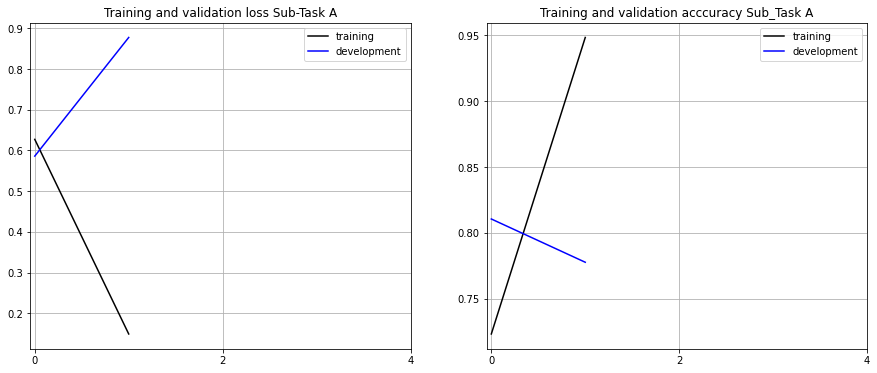

In [104]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=5, task='A')

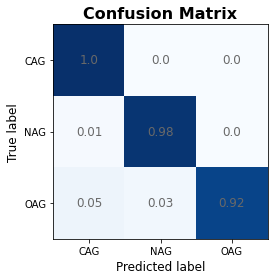

              precision    recall  f1-score   support

         CAG      0.936     0.996     0.965      2718
         NAG      0.981     0.985     0.983      4045
         OAG      0.998     0.924     0.959      2610

    accuracy                          0.971      9373
   macro avg      0.971     0.968     0.969      9373
weighted avg      0.972     0.971     0.971      9373

Weighted f1-score: 0.9711174546795721


In [105]:
# Evaluate model on TRAINING data

# predict using model. Returns logits
pred_labels_train = BERT_model_A.predict(train_features)[0]

# convert logits lo labels
pred_labels_train = from_logits_to_labels(pred_labels_train, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_train, train_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_a, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_a, pred_labels_train, pos_label=1, average='weighted')}")


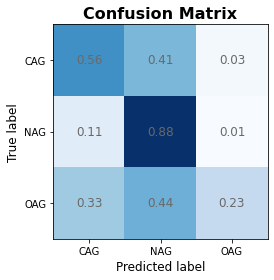

              precision    recall  f1-score   support

         CAG      0.337     0.556     0.419       117
         NAG      0.883     0.883     0.883       836
         OAG      0.703     0.230     0.347       113

    accuracy                          0.778      1066
   macro avg      0.641     0.556     0.550      1066
weighted avg      0.804     0.778     0.775      1066

Weighted f1-score: 0.7750824103774536


In [106]:
# Evaluate model on DEVELOPMENT data

# predict using model. Returns logits
pred_labels_dev = BERT_model_A.predict(dev_features)[0]

# convert logits lo labels
pred_labels_dev = from_logits_to_labels(pred_labels_dev, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_dev, dev_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_a, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_a, pred_labels_dev, pos_label=1, average='weighted')}")

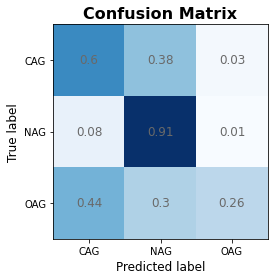

              precision    recall  f1-score   support

         CAG      0.424     0.598     0.496       224
         NAG      0.786     0.906     0.842       690
         OAG      0.820     0.255     0.389       286

    accuracy                          0.693      1200
   macro avg      0.677     0.586     0.576      1200
weighted avg      0.727     0.693     0.669      1200

Weighted f1-score: 0.6694398204264871


In [107]:
# Evaluate model on TEST data

# predict using model. Returns logits
pred_labels_test = BERT_model_A.predict(test_features)[0]

# convert logits lo labels
pred_labels_test = from_logits_to_labels(pred_labels_test, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_test, test_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_a, pred_labels_test, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_a, pred_labels_test, pos_label=1, average='weighted')}")

In [108]:
# save model
BERT_model_A.save_pretrained('drive/MyDrive/w266/saved_models/TRAC-2_BERT_model_A_augm_glove')

## Model Task B

In [ ]:
# delete model if exists
try:
    del BERT_model_B
except:
    pass

In [ ]:
# define the model. Task B is a classification task with 2 labels
BERT_model_B = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# compile model
BERT_model_B.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics=tf.metrics.CategoricalAccuracy()
                    )

In [ ]:
# fit model
training_history = BERT_model_B.fit(train_tf_dataset_b, validation_data=dev_tf_dataset_b, epochs=3)

Epoch 1/3
586/586 [==============================] - 235s 367ms/step - loss: 0.2366 - categorical_accuracy: 0.9092 - val_loss: 0.2404 - val_categorical_accuracy: 0.9296
Epoch 2/3
586/586 [==============================] - 211s 361ms/step - loss: 0.0503 - categorical_accuracy: 0.9849 - val_loss: 0.2118 - val_categorical_accuracy: 0.9343
Epoch 3/3
586/586 [==============================] - 211s 360ms/step - loss: 0.0284 - categorical_accuracy: 0.9917 - val_loss: 0.2913 - val_categorical_accuracy: 0.9362


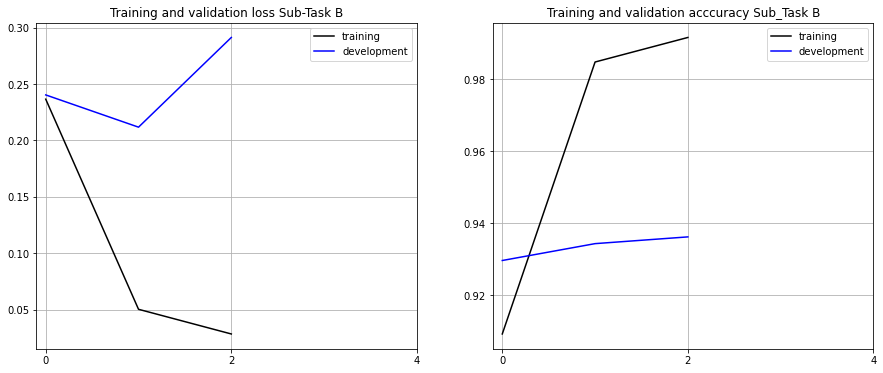

In [ ]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=5, task='B')

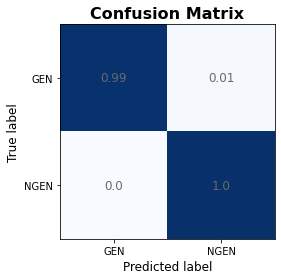

              precision    recall  f1-score   support

         GEN      0.992     0.989     0.991      1854
        NGEN      0.997     0.998     0.998      7519

    accuracy                          0.996      9373
   macro avg      0.995     0.994     0.994      9373
weighted avg      0.996     0.996     0.996      9373

Weighted f1-score: 0.9962639696115768


In [ ]:
# Evaluate model on TRAINING data

# predict using model. Returns logits
pred_labels_train = BERT_model_B.predict(train_features)[0]

# convert logits lo labels
pred_labels_train = from_logits_to_labels(pred_labels_train, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_train, train_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_b, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_b, pred_labels_train, pos_label=1, average='weighted')}")


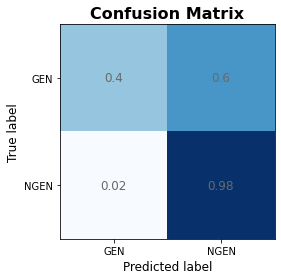

              precision    recall  f1-score   support

         GEN      0.547     0.397     0.460        73
        NGEN      0.957     0.976     0.966       993

    accuracy                          0.936      1066
   macro avg      0.752     0.687     0.713      1066
weighted avg      0.929     0.936     0.931      1066

Weighted f1-score: 0.931465438699833


In [ ]:
# Evaluate model on DEVELOPMENT data

# predict using model. Returns logits
pred_labels_dev = BERT_model_B.predict(dev_features)[0]

# convert logits lo labels
pred_labels_dev = from_logits_to_labels(pred_labels_dev, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_dev, dev_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_b, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_b, pred_labels_dev, pos_label=1, average='weighted')}")

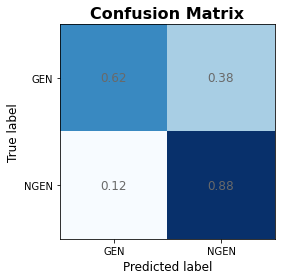

              precision    recall  f1-score   support

         GEN      0.478     0.617     0.539       175
        NGEN      0.931     0.885     0.907      1025

    accuracy                          0.846      1200
   macro avg      0.705     0.751     0.723      1200
weighted avg      0.865     0.846     0.854      1200

Weighted f1-score: 0.853670340989281


In [ ]:
# Evaluate model on TEST data

# predict using model. Returns logits
pred_labels_test = BERT_model_B.predict(test_features)[0]

# convert logits lo labels
pred_labels_test = from_logits_to_labels(pred_labels_test, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_test, test_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_b, pred_labels_test, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_b, pred_labels_test, pos_label=1, average='weighted')}")

In [ ]:
# save model
BERT_model_B.save_pretrained('drive/MyDrive/w266/saved_models/TRAC-2_BERT_model_B_augm_glove')

## References

- Pre-processing data: https://huggingface.co/transformers/preprocessing.html

- Fine-tunning a pre-trained model: https://huggingface.co/transformers/training.html

- BERT: https://huggingface.co/transformers/model_doc/bert.html